### Scratch functions by Pytorch
scractch notebook to develop functions for pytorch code
- random rotation
- custom loss funciton
- Pyramid dataset function

In [1]:
import os
import sys
import math
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

##### download MNIST train data

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
      root="./multigrids/mnist_data",
      train=True,
      download=True,
      transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
      ])
    ),
    batch_size=32,
    shuffle=True,
    pin_memory=True
)

100.1%

Extracting ./multigrids/mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./multigrids/mnist_data/MNIST/raw


0.5%5%

Extracting ./multigrids/mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./multigrids/mnist_data/MNIST/raw


180.4%

Extracting ./multigrids/mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./multigrids/mnist_data/MNIST/raw
Extracting ./multigrids/mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./multigrids/mnist_data/MNIST/raw
Processing...
Done!


In [5]:
train_loader

get data as computing type

In [5]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [16]:
example_data.shape

torch.Size([32, 1, 28, 28])

###### download CIFAR100 trani data

In [2]:
datasets.CIFAR100(
      root="./multigrids/cifar100_data",
      train=False,
      download=False
    )

Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ./multigrids/cifar100_data
    Split: Test

In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100(
      root="./multigrids/cifar100_data",
      train=False,
      download=False,
    transform=transforms.Compose([
        transforms.ToTensor()
        ])
    ),
    batch_size=32
)

In [7]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

#### Code rotate fn

- rotate operation

In [25]:
rotate_ops= transforms.Compose([ 
                transforms.ToPILImage(),
                transforms.RandomRotation([1,359]),
            ])

- New rotate function

In [39]:
def new_rotate_fn(imgs, angle):
    rimgs = []
    for img in imgs:
        rimgs.append(transforms.functional.rotate(transforms.ToPILImage()(img.cpu()), angle))
    return torch.cat([transforms.ToTensor()(rimg).unsqueeze(0) for rimg in rimgs ]) 

- Rotate_ops

In [32]:
rexample_data = []
for i in example_data:
    rexample_data.append(rotate_ops(i))

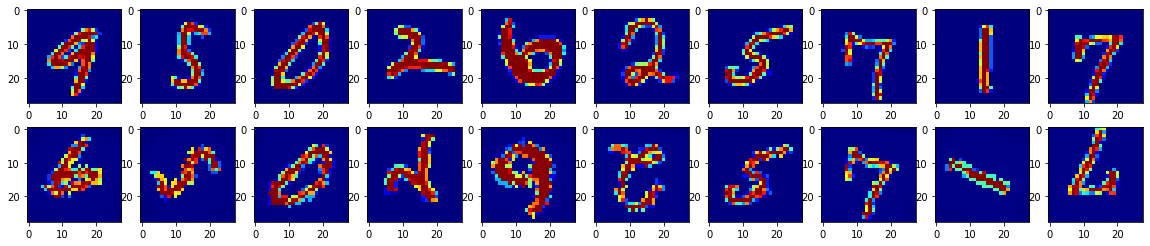

In [36]:
f,a=plt.subplots(2,10,figsize=(20,4))
for i in range(10):
    a[0][i].imshow(np.reshape(example_data[i],(28,28)), cmap='jet')
    a[1][i].imshow(np.reshape(rexample_data[i],(28,28)), cmap='jet')

- Rotate fn

08/21

In [31]:
def rotate_fn(data):
    rotate_ops= transforms.Compose([ 
                transforms.ToPILImage(),
                transforms.RandomRotation([1,359]),
                transforms.ToTensor()
            ])
    rdata = []
    for i in data:
        print(data.size())
        rdata.append(rotate_ops(i).unsqueeze(0)) # unsqueeze prevent depricated 1 dim entry
    return torch.cat(rdata)

In [63]:
a = rotate_fn(example_data)
print(type(a), type(example_data))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [64]:
a.shape

torch.Size([32, 1, 28, 28])

08/22

In [56]:
a = new_rotate_fn(example_data, 90)
print(type(a), type(example_data), a.size())

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 1, 28, 28])


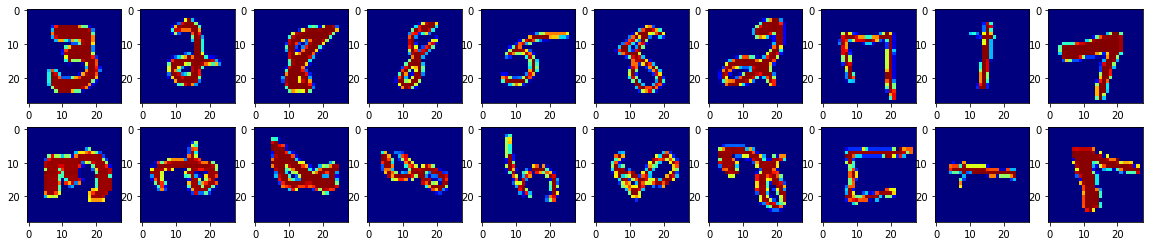

In [57]:
b = a.numpy()
f,ax = plt.subplots(2,10,figsize=(20,4))
for i in range(10):
    ax[0][i].imshow(np.reshape(example_data[i], (28,28)), cmap='jet')
    ax[1][i].imshow(np.reshape(b[i],(28,28)), cmap='jet')
plt.show()

-----------------
### Note

Args in rotation operation in pytorch takes `degree`, while tensorflow takes `radian`

-------------
Develop Rotate function for multiple channel data

In [37]:
def multi_rotate_fn(imgs, angle):
    """INPUT
            imgs: tensor(#batch, 3, 32,32) or (#batch, 64, 2,2)
    """
    rimgs = []
    for img in imgs:
        cimg = transforms.functional.rotate(transforms.ToPILImage()(img.cpu()), angle)
        cimg_np = transforms.ToTensor()(cimg).numpy()
        rimgs.append(np.expand_dims(cimg_np, axis=0))
    rimgs_np = np.concatenate(rimgs, axis=0)
    return torch.from_numpy(rimgs_np)

In [38]:
a = multi_rotate_fn(example_data, 90)
print(type(a), type(example_data), a.size())

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])


In [12]:
example_data.numpy().shape

(32, 3, 32, 32)

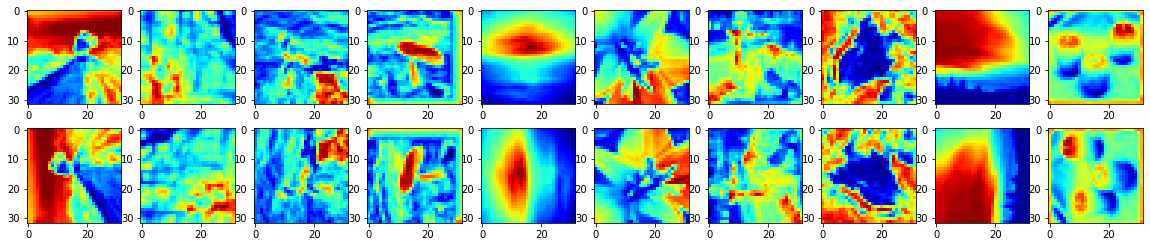

In [39]:
b = a.numpy()
f,ax = plt.subplots(2,10,figsize=(20,4))
for i in range(10):
    ax[0][i].imshow(np.reshape(example_data[i,0], (32,32)), cmap='jet')
    ax[1][i].imshow(np.reshape(b[i,0],(32,32)), cmap='jet')
plt.show()

- Mean and Std in CIFAR100

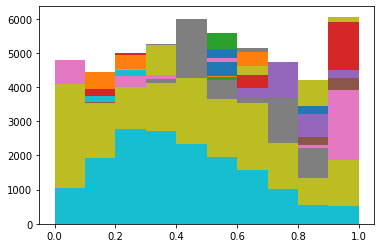

In [44]:
fig = plt.figure()
for batch_idx, (iexample_data, iexample_targets) in examples:
    plt.hist(iexample_data.numpy()[:,0,:,:].ravel())

--------------------
#### Custam loss
[Custam Loss functirons](https://discuss.pytorch.org/t/custom-loss-functions/29387)

- Examples
```
def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss
```

Rotate-Invariant Loss function by tesorflow

In [ ]:
### Tnesorflow --> Pytorch version
def loss_torch_fn(output_layer,
                  input_layer,
                  encoded_imgs,
                  encoder,
                  batch_size=32, dangle=2, c_lambda=1
                  ):

    def rotate_opetation(imgs, angle=1):
        """INPUT:
                angle:  Radian
        """
        rimgs = []
        for img in imgs:
            rimgs.append(transforms.functional.rotate(img, angle).unsqueeze(0))
        return torch.cat(rimgs)

    # loss lists
    loss_reconst = [] # first term
    loss_hidden  = [] # seconds term
    angle_list = [i*math.pi/180 for i in range(1,360,dangle)]
    for angle in angle_list:
        rimgs = rotate_opetation(output_layer ,angle=angle) # R_theta(x_hat)
        rencoded_imgs = rotate_opetation(encoded_imgs, angle=angle) # Z(R(x))

        # loss
        loss_reconst.append(torch.mean((input_layer - rimgs)**2) )
        loss_hidden.append(torch.mean((encoded_imgs - rencoded_imgs)**2))

    # Get min-max
    reconst = torch.min(torch.stack(loss_reconst))
    hidden  = torch.max(torch.stack(loss_reconst))

    return reconst + c_lambda*hidden

Translate to Pytorch

In [65]:
c = torch.randn(3,3)
c

tensor([[ 1.6189, -0.7738, -0.7542],
        [-0.4852, -0.3012,  1.5171],
        [ 0.4657, -0.0723, -0.4064]])

In [66]:
c*4

tensor([[ 6.4756, -3.0950, -3.0170],
        [-1.9406, -1.2048,  6.0686],
        [ 1.8626, -0.2891, -1.6254]])

-------------------
### Adjust Pyramid Dataset

In [49]:
%reload_ext autoreload
%autoreload 2

In [51]:
from multigrids.forTak2 import PyramidDataset

In [52]:
# test with test data
test_data = datasets.CIFAR10(
      root="./multigrids/cifar_data",
      train=False,
      download=False,
    )

In [29]:
type(test_data)

torchvision.datasets.cifar.CIFAR10

In [23]:
test_data.data.shape

(10000, 32, 32, 3)

In [24]:
test_data_tp = np.transpose(test_data.data,axes=(0,-1,1,2))

In [46]:
test_data_rx = np.rollaxis(test_data.data,-1,1)
test_data_rx.shape

(10000, 3, 32, 32)

In [25]:
test_data_tp.shape

(10000, 3, 32, 32)

In [33]:
test_target = test_data.targets

In [39]:
tensor_x = torch.stack([torch.Tensor(i) for i in test_data_tp])
tensor_y = torch.stack([torch.Tensor(i) for i in np.array(test_target).reshape(-1,1)])

my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)

In [43]:
my_dataset

In [60]:
pdata = PyramidDataset(test_data, test_data, layerReses=(32,16,8,4,2), 
                       transform=transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            ]) ,
                       channel_last=True
                      )


Preparing the data...
1.0 32 32
2.0 32 16
4.0 32 8
8.0 32 4
16.0 32 2


In [61]:
pdata

In [62]:
newloader = torch.utils.data.DataLoader(pdata, batch_size=32)
examples = enumerate(newloader)
batch_idx, (example_data, example_targets) = next(examples)

In [69]:
example_data[0].shape

torch.Size([32, 3, 32, 32])

In [70]:
type(example_data[0])

torch.Tensor

In [71]:
type(example_data)

list

In [72]:
a = np.asarray(example_data)

ValueError: only one element tensors can be converted to Python scalars